In [3]:
# import libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec as gs
import subprocess as sp
from scipy.stats import gaussian_kde
#import multiprocessing as mp

In [4]:
# function to check whether variable is a number
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [5]:
# function to find an index of an element in a sorted list (faster than numpy)
def bissec(A,x):
    n = len(A)-1
    if (x < A[0]):
        return 0
    elif (x > A[n]):
        return n+1
    n1 = 0
    n2 = n
    while ((n2-n1)>1):
        nm = (n1+n2)/2
        if ((x-A[nm]) > 0):
            n1 = nm
        else:
            n2 = nm
    return n1

In [6]:
# this function builds the flag.dat file containing etoile input parameters
def genflag(type):
    
    #this function builds tha flag.dat file containing etoile parameters
    global lwlim
    global uwlim
    global lib
    parset = {'derrv': 0, 'deratmos': 0, 'compare': 0}
    parset[type] = 1
    if lib == 5:
        libpath = '../code/dnm/parameters_standard_V20130201.dat'
    elif lib == 4:
        libpath = '../code/dnm/parameters_standard_coelho05.dat'
    with open('flag.dat', 'w') as flgfil:
        flgfil.write('DERIVE_RADIAL_VELOCITY....... '+str(parset['derrv'])+
                     '\n     write_logs................... 2\n \nNormalise_Object_Continuum... 1'
                     '\n     display_spectrum............. 0\n     reject_high.................. 0'
                     '\n     degree....................... 4\n     sigma_rej.................... 1.8'
                     '\n     nb_kept_pixel_min............ 15\n \nNormalise_Object_Fluxes...... 1\n '
                     '\nSelect_Wavelength_Domain_Temp 1\n     wave_blue.................... '+'%.2f'%lwlim+'\n     '
                     'wave_red..................... '+'%.2f'%uwlim+'\n \nNormalise_Template_Continuum. 1\n     '
                     'display_spectrum............. 0\n     reject_high.................. 0\n     '
                     'degree....................... 4\n     sigma_rej.................... 1.8\n     '
                     'nb_kept_pixel_min............ 15\n \nNormalise_Template_Fluxes.... 1\n \n'
                     'Prepare_Both_Spectra......... 0\n     vmax......................... 700.0\n \n'
                     'Calculate_Analyse_CC_Peak\n     nbst0........................  60\n     '
                     'nbst1........................ 225\n     step0........................  10.0\n     '
                     'step1........................   0.2\n \nDisplay_Overplotted_Spectra.. 1\n \n     '
                     '-----------------------------------\n \nLIBRARY_OF_ATMOSPHERIC_PARAMETERS\n'
                     'Param_Std '+libpath+'\n\n     '
                     '-----------------------------------\n \nCOMPARE_SPECTRA.............. '+
                     str(parset['compare'])+'\nDERIVE_ATMOSPHERIC_PARAMETERS '+
                     str(parset['deratmos'])+'\n     Match_Orders................. 0\n     '
                     'Convolve..................... 0\n     Graph........................ 0\n     '
                     'Write........................ 1\n     Number_Of_Degrees_Of_Freedom. 4')

In [7]:
# set parameters to run etoile in one line depending on goal (derive RV, derive atmos.param., compare)
def run_etoile(inptf, lib, modeconf):
    
    #simplifying the name
    sname = inptf.split('.')[0]
    #logging etoile outputs
    logf = open('etoile_'+sname+'.log', 'w')
    print('running etoile for '+sname+' ...'),
    #Etoile is open in a subprocess
    pr = sp.Popen(['./etoile'], shell=True, close_fds=True,
             stdin=sp.PIPE, stdout=logf)
    #depending on the running mode, different inputs must be given
    if modeconf['deratmos'] == 1:
        pr.communicate('0\n'+inptf+'\n'+inptf.split('.')[0]+'\n'+str(lib)+'\n')
    elif modeconf['derrv'] != 0:
        pr.communicate('0\n'+inptf+'\n'+inptf.split('.')[0]+'\n'+str(lib)+'\n2.5\n')
    elif modeconf['compare'] != 0:
        if is_number(modeconf['compare']):
            #if the key 'compare' is a number, it must represent a library index
            pr.communicate('0\n'+inptf+'\n'+inptf.split('.')[0]+'\n'+str(lib)+'\n'+str(modeconf['compare'])+'\n')
        else:
            #if not, must be a filename
            prefix = modeconf['compare'].split('.')[0]
            pr.communicate('0\n'+inptf+'\n'+inptf.split('.')[0]+'\n0\n'+modeconf['compare']+'\n'+prefix+'\n')
    print(' done.')

In [8]:
#this function builds and returns the best matching dictionary for RV correction or correlation plot
#catching best correlation template
def get_index():
    
    bestmatch = {}
    with open('atmosphericParameters.dat') as apar:
        lines = [raw.strip().split() for raw in apar]
        for n, cols in enumerate(lines):
            if len(cols) == 1:
                bestmatch[cols[0]] = {'lib': '', 'id': '', 'rv': ''}
                bestmatch[cols[0]]['lib'] = lines[n+1][0]

    #getting its library index
    if lib == 5:
        with open('names_miles91.lis') as milst:
            libn = []
            libi = []
            for cols in [raw.strip().split() for raw in milst]:
                if len(cols) == 2:
                    libi.append(cols[0])
                    libn.append(cols[1])
        for star in bestmatch.keys():
            bestmatch[star]['id'] = libi[libn.index(bestmatch[star]['lib'])]
    elif lib == 4:
        for star in bestmatch.keys():
            bestmatch[star]['id'] = bestmatch[star]['lib'].strip('star')
    
    return bestmatch

In [25]:
# run ETOILE to find best RV CC ref for each star

#the main program starts here
#window and library definitions
lwlim = 4810
uwlim = 5980
lib = 5 # MILES=5, COELHO=4

# before continuing, create input list with the output from Pamp2Comb (edit with less files if needed)
# ls *combined.ascii > inputlist 

#importing spectra from list
with open('inputlist') as inl:
    inlist = [raw.strip() for raw in inl]
for n, f in enumerate(inlist):
    clnm = f.split('/')[-1]
    shutil.copy(f, clnm)
    inlist[n] = clnm
    #here we cut the spectrum to the specified lambda.
    #this is useful when you have obs spectra larger than library
    spc = np.genfromtxt(clnm, unpack=True, skip_header=1)
    #except if you specified lambdas out of the range of the spectra, then it will take no effect
    if lwlim < spc[0][0]:
        lwlim = spc[0][0]
    if uwlim > spc[0][-1]:
        uwlim = spc[0][-1]
    cutidxs = [bissec(spc[0], lwlim), bissec(spc[0], uwlim)]
    lbd = spc[0][cutidxs[0]:cutidxs[1]]
    flx = spc[1][cutidxs[0]:cutidxs[1]]
    spdata = np.transpose([lbd, flx])
    np.savetxt(clnm, spdata, header=str(len(lbd)), comments='')    

#configuring etoile run method and generating config file
mconf = {'derrv': 0, 'deratmos': 1, 'compare': 'none'}

In [60]:
#generating flag.dat
genflag('deratmos')

#cleaning previous runs
try:
    os.remove('atmosphericParameters.dat')
    os.remove('spec2plot.tab')
except:
    pass

#running etoile for each star
for f in inlist:
    run_etoile(f, lib, mconf)
    try:
        os.remove('spec2plot.tab')
    except:
        pass

running etoile for Ter9_0056cb ...

KeyboardInterrupt: 

In [15]:
#getting the best matching library indexes
os.system('rm etoile*.log')
#bestmatch = get_index()

#building template file
with open('../code/dnm/templatesForCC.txt', 'w') as tplf:
    tplf.write(str(len(bestmatch.keys()))+'\n')
    for n, star in enumerate(bestmatch.keys()):
        tplf.write(star+' '+str(n+1)+' '+bestmatch[star]['lib']+' '+bestmatch[star]['id']+'\n')

In [68]:
# derive radial velocities with cross-correlation

#lwlim = lwlim-100
#uwlim = uwlim+100

lwlim = 4790
uwlim = 6000

#configuring etoile method
mconf['deratmos'] = 0
mconf['derrv'] = 1
genflag('derrv')


#cleaning previous runs
try:
    os.remove('radialVelocities.dat')
    os.remove('spec2plot.tab')
except:
    pass

#running etoile
for f in inlist:
    run_etoile(f, lib, mconf)
try:
    os.remove('spec2plot.tab')
except:
    pass

 running etoile for Ter9_0056cb ...  done.
running etoile for Ter9_0072cb ...  done.
running etoile for Ter9_0077cb ...  done.
running etoile for Ter9_0081cb ...  done.
running etoile for Ter9_0084cb ...  done.
running etoile for Ter9_0086cb ...  done.
running etoile for Ter9_0089cb ...  done.
running etoile for Ter9_0092cb ...  done.
running etoile for Ter9_0399cb ...  done.
running etoile for Ter9_0408cb ...  done.
running etoile for Ter9_0411cb ...  done.
running etoile for Ter9_0415cb ...  done.
running etoile for Ter9_0418cb ...  done.
running etoile for Ter9_0426cb ...  done.
running etoile for Ter9_0427cb ...  done.
running etoile for Ter9_0428cb ...  done.
running etoile for Ter9_0437cb ...  done.
running etoile for Ter9_0439cb ...  done.
running etoile for Ter9_0440cb ...  done.
running etoile for Ter9_0444cb ...  done.
running etoile for Ter9_0449cb ...  done.
running etoile for Ter9_0450cb ...  done.
running etoile for Ter9_0461cb ...  done.
running etoile for Ter9_0473cb ..

In [17]:
#lwlim = 4790
#uwlim = 6000
#bestmatch = {}
#with open('inputlist') as ipl:
#    for row in [raw.strip().split('/') for raw in ipl]:
#        nm = row[1].strip('.ascii')
#        bestmatch[nm] = {'lib': '', 'id': '', 'rv': ''}

#retrieving RV values from output file
snames = bestmatch.keys()
with open('radialVelocities.dat') as rvf:
    for cols in [raw.strip().split() for raw in rvf]:
        fname = cols[0].replace('.0', '').replace('-1000', '')
        bestmatch[fname]['rv'] = float(cols[-3])

ctrlbd = np.mean([lwlim, uwlim])
        
#correcting and saving each spectrum
for s in bestmatch.keys():
    spec = np.genfromtxt(s+'.ascii', unpack=True, skip_header=1)
    spec[0] = spec[0] - (bestmatch[s]['rv'] * ctrlbd / 299792.458)
    np.savetxt('rv_'+s+'.ascii', np.transpose(spec), header=str(len(spec[0])), comments='')

In [20]:
mconf = {'derrv': 0, 'deratmos': 1, 'compare': 'none'}
lib = 4

#checking rv correction
%matplotlib inline
spname = 'Ter9_0056cb'
#libname= 'miles91'

rvlib = bestmatch[spname]['id']
mconf['deratmos'] = 0
mconf['derrv'] = 0
mconf['compare'] = rvlib
genflag('compare')
#running etoile for the match comparison
run_etoile('rv_'+spname+'.ascii', lib, mconf)
print('star '+spname+' matched library index '+rvlib+'\n')
os.rename('spec2plot.tab', spname+'_rvfit.tab')

print('radial velocity: '+str(bestmatch[spname]['rv']))
#print('../libraries/'+libname+'/m%04dV'%int(bestmatch[spname]['id']))
sp_o = np.genfromtxt(spname+'.ascii', unpack=True, skip_header=1)
sp_r = np.genfromtxt('rv_'+spname+'.ascii', unpack=True, skip_header=1)
libsp = np.genfromtxt(spname+'_rvfit.tab', unpack=True, skip_header=1)
plt.plot(sp_o[0], sp_o[1], 'r--', lw=0.7, label='original')
plt.plot(sp_r[0], sp_r[1], 'g-', lw=0.8, label='corrected')
plt.plot(libsp[0], libsp[2], 'k-', lw=0.8, label='library')
plt.plot()
plt.text(0.99, 0.02, 'rv='+str(bestmatch[spname]['rv']), ha='right', va='bottom', transform=plt.gca().transAxes)
plt.gca().set_xlabel('Wavelength [$\AA$]')
plt.gca().set_ylabel('normalized flux')
plt.gca().set_xlim([5120, 5200])
plt.gca().set_ylim([0.2, 0.6])
plt.legend()
plt.show()

running etoile for rv_Ter9_0056cb ...  done.
star Ter9_0056cb matched library index 



OSError: [Errno 2] No such file or directory

In [26]:
#configuring etoile method
mconf['deratmos'] = 1
mconf['derrv'] = 0
mconf['compare'] = 'none'
genflag('deratmos')

#running etoile for deriving the atmospheric parameters
try:
    os.remove('atmosphericParameters.dat')
except:
    pass
for f in inlist:
    run_etoile('rv_'+f, lib, mconf)
os.remove('spec2plot.tab')

running etoile for rv_Ter9_0056cb ...  done.
running etoile for rv_Ter9_0072cb ...  done.
running etoile for rv_Ter9_0077cb ...  done.
running etoile for rv_Ter9_0081cb ...  done.
running etoile for rv_Ter9_0084cb ...  done.
running etoile for rv_Ter9_0086cb ...  done.
running etoile for rv_Ter9_0089cb ...  done.
running etoile for rv_Ter9_0092cb ...  done.
running etoile for rv_Ter9_0399cb ...  done.
running etoile for rv_Ter9_0408cb ...  done.
running etoile for rv_Ter9_0411cb ...  done.
running etoile for rv_Ter9_0415cb ...  done.
running etoile for rv_Ter9_0418cb ...  done.
running etoile for rv_Ter9_0426cb ...  done.
running etoile for rv_Ter9_0427cb ...  done.
running etoile for rv_Ter9_0428cb ...  done.
running etoile for rv_Ter9_0437cb ...  done.
running etoile for rv_Ter9_0439cb ...  done.
running etoile for rv_Ter9_0440cb ...  done.
running etoile for rv_Ter9_0444cb ...  done.
running etoile for rv_Ter9_0449cb ...  done.
running etoile for rv_Ter9_0450cb ...  done.
running et

In [29]:
#generating best fit file tables
mconf['derrv'] = 0
mconf['deratmos'] = 0

#again, getting the best matching library indexes
bestmatch2 = get_index()
#print(bestmatch2)
for f in inlist:
    starn = f.split('.')[0]
    libid = bestmatch2['rv_'+starn]['id']
    #configuring for the specific library spectrum
    mconf['compare'] = libid
    genflag('compare')
    #and running etoile for the match comparison
    run_etoile('rv_'+f, lib, mconf)
    print('star '+starn+' matched library index '+libid+'\n')
    os.rename('spec2plot.tab', starn+'_fit.tab')

running etoile for rv_Ter9_0056cb ...  done.
star Ter9_0056cb matched library index 1715

running etoile for rv_Ter9_0072cb ...  done.
star Ter9_0072cb matched library index 0771

running etoile for rv_Ter9_0077cb ...  done.
star Ter9_0077cb matched library index 2463

running etoile for rv_Ter9_0081cb ...  done.
star Ter9_0081cb matched library index 0816

running etoile for rv_Ter9_0084cb ...  done.
star Ter9_0084cb matched library index 0816

running etoile for rv_Ter9_0086cb ...  done.
star Ter9_0086cb matched library index 2380

running etoile for rv_Ter9_0089cb ...  done.
star Ter9_0089cb matched library index 0816

running etoile for rv_Ter9_0092cb ...  done.
star Ter9_0092cb matched library index 0816

running etoile for rv_Ter9_0399cb ...  done.
star Ter9_0399cb matched library index 2412

running etoile for rv_Ter9_0408cb ...  done.
star Ter9_0408cb matched library index 2832

running etoile for rv_Ter9_0411cb ...  done.
star Ter9_0411cb matched library index 0296

running et

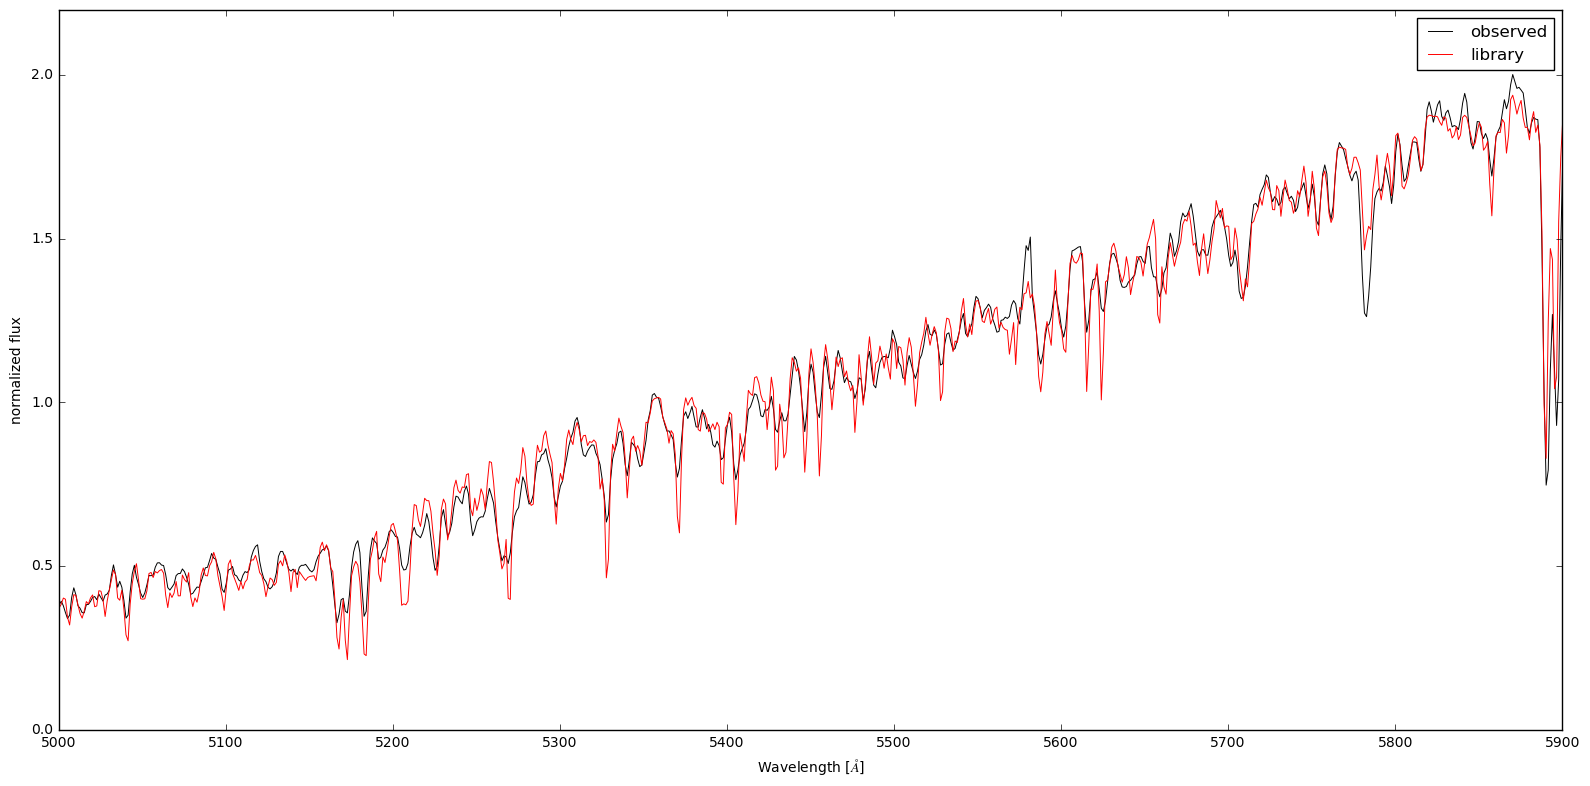

In [34]:
#checking etoile fit
#%matplotlib inline
spname = 'Ter9_0077cb'
sp_c = np.genfromtxt(spname+'_fit.tab', unpack=True, skip_header=1)
plt.figure(figsize=(16,8))
plt.plot(sp_c[0], sp_c[1], 'k-', lw=0.7, label='observed')
plt.plot(sp_c[0], sp_c[2], 'r-', lw=0.7, label='library')
plt.gca().set_xlabel('Wavelength [$\AA$]')
plt.gca().set_ylabel('normalized flux')
plt.axis([5000, 5900, 0.0, 2.2])
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [27]:

obj = 'Ter9'
starpars = {}
with open('atmosphericParameters.dat') as ap:
    for line in [raw.strip().split() for raw in ap]:
        if len(line) == 1:
            star = line[0].split('_')[-1].strip('cb')
            if star not in starpars.keys():
                starpars[star] = {'tpn': [], 'sim': [], 'teff': [], 'lg': [], 'met': [], 'alp': []}
        elif len(line) > 4:
            starpars[star]['tpn'].append(line[0])
            starpars[star]['sim'].append(float(line[1]))
            starpars[star]['teff'].append(float(line[2]))
            starpars[star]['lg'].append(float(line[3]))
            starpars[star]['met'].append(float(line[4]))
            starpars[star]['alp'].append(float(line[5]))

finalpars = {}
rvl = []
mts = []
pfil = open('parameters_coelho.dat', 'w')
pfil.write('%-8s %5s %8s  %9s   %10s   %10s'%('star_id', 'RV', 'Teff', 'logG', '[Fe/H]', '[Mg/H]\n'))
for s in sorted(starpars.keys()):
    #print s
    for entry in starpars[s].keys():
        starpars[s][entry] = np.array(starpars[s][entry])
    maskidx = []
    starpars[s]['sim'] = starpars[s]['sim']/starpars[s]['sim'][0]
    for n, m in enumerate(starpars[s]['sim']):
        #exclusion criteria
        if (m > 1.1) or (starpars[s]['lg'][n] < -900.) or (starpars[s]['alp'][n] < -900.) or not (\
        (starpars[s]['lg'][n] <= 4.9 - 0.0002 * starpars[s]['teff'][n]) and\
        (starpars[s]['lg'][n] >= -12.3 + 0.0025 * starpars[s]['teff'][n])):
            maskidx.append(n)
    for entry in starpars[s].keys():
        starpars[s][entry] = np.delete(starpars[s][entry], maskidx)
    if len(starpars[s]['teff']) > 1:
        finalpars[s] = {}
        weight = 1/(np.array(starpars[s]['sim'])**2)
        teff = np.average(starpars[s]['teff'], weights=weight)
        finalpars[s]['teff'] = teff
        logg = np.average(starpars[s]['lg'], weights=weight)
        finalpars[s]['logg'] = logg
        met = np.average(starpars[s]['met'], weights=weight)
        finalpars[s]['met'] = met
        mts.append(met)
        alp =np.average(starpars[s]['alp'], weights=weight)
        finalpars[s]['alp'] = alp
        eteff = np.sqrt(np.average((starpars[s]['teff']-teff)**2, weights=weight))
        finalpars[s]['eteff'] = eteff
        elogg = np.sqrt(np.average((starpars[s]['lg']-logg)**2, weights=weight))
        finalpars[s]['elogg'] = elogg
        emet = np.sqrt(np.average((starpars[s]['met']-met)**2, weights=weight))
        finalpars[s]['emet'] = emet
        ealp = np.sqrt(np.average((starpars[s]['alp']-alp)**2, weights=weight))
        finalpars[s]['ealp'] = ealp
        spname = obj+'_'+s+'cb'
        rv = bestmatch[spname]['rv']
        rvl.append(rv)
        finalpars[s]['rv'] = rv
        pfil.write('%-8s %7.2f  %4.0f±%-4.0f %5.2f±%4.2f %6.2f±%4.2f %6.2f±%4.2f\n'%(s, rv, teff, eteff, logg, elogg, met, emet, alp, ealp))
pfil.close()

In [18]:
#C A U T I O N !!!!!
os.system('rm *.log *.ascii spec2plot* atmospher*')

256

99.75 187.21
501


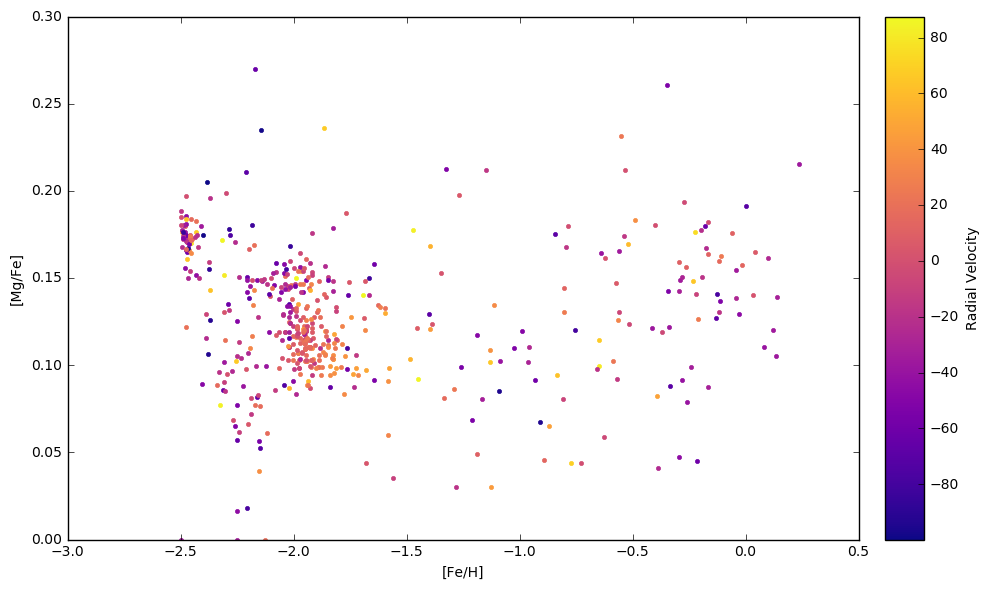

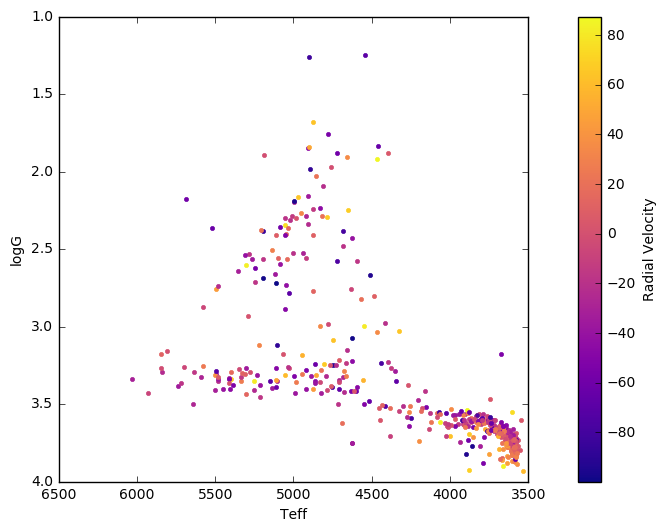

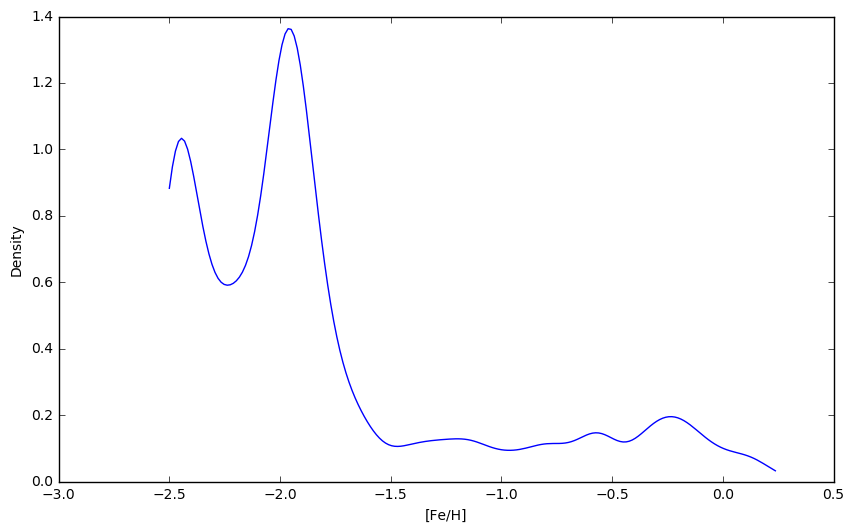

In [28]:
#todo: read final parameters from file...

rvmin = -100
rvmax = 100

rvl = np.array(rvl)
delmask = []
for n in range(len(rvl)):
    if (rvl[n] < rvmin) or (rvl[n] > rvmax):
        delmask.append(n)
rvl = np.delete(rvl, delmask)
mnrv = abs(min(rvl))
nrvl = rvl + mnrv
mxrv = max(nrvl)
print mnrv, mxrv
print len(rvl)

f1 = plt.figure(figsize = (10,6))
grid = gs.GridSpec(1, 2, width_ratios=[10, 0.5]) 
ax1 = plt.subplot(grid[0])
cmap = plt.get_cmap('plasma')
for s in sorted(finalpars.keys()):
    if (finalpars[s]['rv'] > rvmin) and (finalpars[s]['rv'] < rvmax):
        ax1.plot(finalpars[s]['met'], finalpars[s]['alp'], marker='.', color=cmap((finalpars[s]['rv']+mnrv)/mxrv))
ax1.set_xlabel('[Fe/H]')
ax1.set_ylabel('[Mg/Fe]')
cbr = plt.subplot(grid[1])
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=min(rvl), vmax=max(rvl))
cb1 = mpl.colorbar.ColorbarBase(cbr, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Radial Velocity')
plt.tight_layout()

f2 = plt.figure(figsize=(7,6))
grid2 = gs.GridSpec(1, 2, width_ratios=[10, 0.5]) 
ax2 = plt.subplot(grid2[0])
for s in sorted(finalpars.keys()):
    if (finalpars[s]['rv'] > -100) and (finalpars[s]['rv'] < 100):
        ax2.plot(finalpars[s]['teff'], finalpars[s]['logg'], marker='.', color=cmap((finalpars[s]['rv']+mnrv)/mxrv))
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.set_xlabel('Teff')
ax2.set_ylabel('logG')
cbr2 = plt.subplot(grid2[1])
cb2 = mpl.colorbar.ColorbarBase(cbr2, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb2.set_label('Radial Velocity')

f3 = plt.figure(figsize=(10,6))
ax3 = f3.add_subplot(111)
density = gaussian_kde(mts)
xs = np.linspace(min(mts), max(mts), 200)
density.covariance_factor = lambda : .12
density._compute_covariance()
ax3.plot(xs, density(xs), 'b-')
ax3.set_xlabel('[Fe/H]')
ax3.set_ylabel('Density')
plt.show()
    